In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
import datetime



In [12]:
msft = yf.Ticker("GOOG")
print(msft)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



df = msft.history(period="5y")
print(df)

df = df[['Close']]
df


yfinance.Ticker object <GOOG>
                                 Open        High         Low       Close  \
Date                                                                        
2019-08-15 00:00:00-04:00   58.108875   58.725175   58.039454   58.296661   
2019-08-16 00:00:00-04:00   58.910465   59.068786   58.523904   58.813076   
2019-08-19 00:00:00-04:00   59.436865   60.280902   59.436865   59.854389   
2019-08-20 00:00:00-04:00   59.694572   59.735027   59.038317   59.067284   
2019-08-21 00:00:00-04:00   59.589690   59.881857   59.304012   59.494797   
...                               ...         ...         ...         ...   
2024-08-08 00:00:00-04:00  162.343994  165.500000  162.029999  163.839996   
2024-08-09 00:00:00-04:00  161.645004  165.520004  160.929993  165.389999   
2024-08-12 00:00:00-04:00  165.994995  166.699997  163.550003  163.949997   
2024-08-13 00:00:00-04:00  165.184998  166.539993  164.770004  165.929993   
2024-08-14 00:00:00-04:00  164.210007  164.960

,Close
Date,
2019-08-15 00:00:00-04:00,58.296661
2019-08-16 00:00:00-04:00,58.813076
2019-08-19 00:00:00-04:00,59.854389
2019-08-20 00:00:00-04:00,59.067284
2019-08-21 00:00:00-04:00,59.494797
...,...
2024-08-08 00:00:00-04:00,163.839996
2024-08-09 00:00:00-04:00,165.389999
2024-08-12 00:00:00-04:00,163.949997


In [13]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

shifted_df_np = shifted_df.to_numpy()
shifted_df_np
print(shifted_df_np.shape)

#Day 1     #Todays close   #Close day -1      Close day 2   close day -3 


(1251, 8)


In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

X = shifted_df_np[:, 1:]

y = shifted_df_np[:, 0]

X.shape, y.shape
print(X)

X = dc(np.flip(X, axis=1))
X
split_index = int(len(X) * .95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape



[[-0.93240187 -0.90509698 -0.90386887 ... -0.89872776 -0.91361546
  -0.92099866]
 [-0.9198348  -0.93240187 -0.90509698 ... -0.90998104 -0.89872776
  -0.91361546]
 [-0.92058455 -0.9198348  -0.93240187 ... -0.90386887 -0.90998104
  -0.89872776]
 ...
 [ 0.61011954  0.58795908  0.54378126 ...  0.54220858  0.65315356
   0.71105664]
 [ 0.58953176  0.61011954  0.58795908 ...  0.54077879  0.54220858
   0.65315356]
 [ 0.61783985  0.58953176  0.61011954 ...  0.54378126  0.54077879
   0.54220858]]


(torch.Size([1188, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1188, 1]),
 torch.Size([63, 1]))

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [16]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size,
                         self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 16, 2)
model.to(device)
model



torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


learning_rate = 0.003
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


Epoch: 1

Val Loss: 0.197
***************************************************

Epoch: 2

Val Loss: 0.081
***************************************************

Epoch: 3

Val Loss: 0.039
***************************************************

Epoch: 4

Val Loss: 0.011
***************************************************

Epoch: 5

Val Loss: 0.005
***************************************************

Epoch: 6

Val Loss: 0.005
***************************************************

Epoch: 7

Val Loss: 0.009
***************************************************

Epoch: 8

Val Loss: 0.004
***************************************************

Epoch: 9

Val Loss: 0.004
***************************************************

Epoch: 10

Val Loss: 0.004
***************************************************

Epoch: 11

Val Loss: 0.006
***************************************************

Epoch: 12

Val Loss: 0.007
***************************************************

Epoch: 13

Val Loss: 0.004
**********************

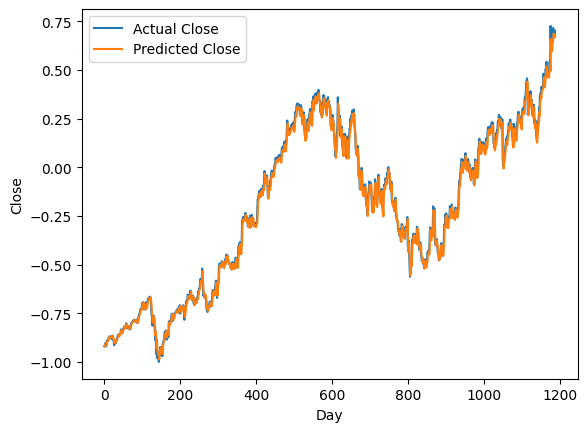

torch.Size([1188, 1])
(1188, 1)
(1188,)


In [18]:
plt.plot(y_train, label='Actual Close')

plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

print(y_train.shape)
print(predicted.shape)
train_predictions = predicted.flatten()
print(train_predictions.shape)


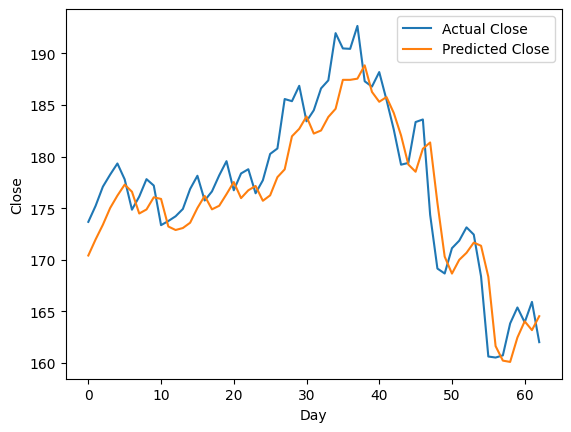

array([170.42365877, 171.97869023, 173.3994501 , 175.02105661,
       176.22613647, 177.29054531, 176.5987175 , 174.49031969,
       174.88303708, 176.06247748, 175.90355449, 173.23195561,
       172.89330622, 173.08507274, 173.59891263, 175.02153605,
       176.19732856, 174.89477704, 175.24203962, 176.36469798,
       177.53893544, 175.98164854, 176.73865062, 177.16004251,
       175.72405322, 176.25010833, 178.0107266 , 178.76790377,
       181.9711109 , 182.69422719, 183.89058546, 182.23376741,
       182.53307794, 183.84035712, 184.63378808, 187.43701122,
       187.43746147, 187.55071703, 188.84327124, 186.26944419,
       185.31236257, 185.76931203, 184.2289722 , 182.05570029,
       179.23922384, 178.53563941, 180.76367971, 181.37246483,
       175.52622911, 170.31442215, 168.67163702, 170.00406789,
       170.68240475, 171.67447694, 171.36555265, 168.36170383,
       161.6484373 , 160.24167282, 160.11614367, 162.48007314,
       164.0478076 , 163.19638559, 164.54473378])

In [19]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train


test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


test_predictions



Test Results:
                        Date      Actual   Predicted
0  2024-05-15 00:00:00-04:00  173.682360  170.423659
1  2024-05-16 00:00:00-04:00  175.230591  171.978690
2  2024-05-17 00:00:00-04:00  177.088469  173.399450
3  2024-05-20 00:00:00-04:00  178.257157  175.021057
4  2024-05-21 00:00:00-04:00  179.335924  176.226136
..                       ...         ...         ...
58 2024-08-08 00:00:00-04:00  163.839995  160.116144
59 2024-08-09 00:00:00-04:00  165.389998  162.480073
60 2024-08-12 00:00:00-04:00  163.949998  164.047808
61 2024-08-13 00:00:00-04:00  165.929994  163.196386
62 2024-08-14 00:00:00-04:00  162.029998  164.544734

[63 rows x 3 columns]
                        Date      Actual   Predicted   Signal
0  2024-05-15 00:00:00-04:00  173.682360  170.423659     Sell
1  2024-05-16 00:00:00-04:00  175.230591  171.978690     Sell
2  2024-05-17 00:00:00-04:00  177.088469  173.399450     Sell
3  2024-05-20 00:00:00-04:00  178.257157  175.021057     Sell
4  2024-05-21 00:

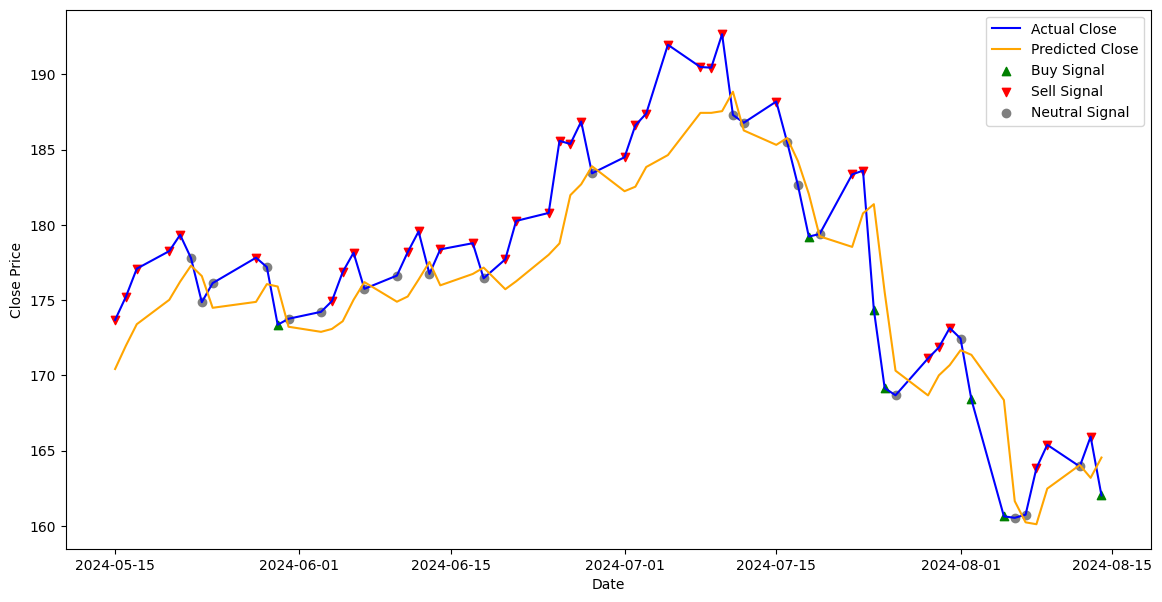

In [20]:
test_dates = df.index[-len(new_y_test):]

# Create dataframe with dates, actual and predicted values
test_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': new_y_test,
    'Predicted': test_predictions
})
print("Test Results:")
print(test_results_df)


def generate_trading_signals(test_results_df, neutral_threshold=0.01):
    test_results_df['Signal'] = 'Neutral'

    test_results_df.loc[test_results_df['Predicted'] >
                        test_results_df['Actual'] * (1 + neutral_threshold), 'Signal'] = 'Buy'
    test_results_df.loc[test_results_df['Predicted'] <
                        test_results_df['Actual'] * (1 - neutral_threshold), 'Signal'] = 'Sell'

    return test_results_df


test_results_df_with_signals = generate_trading_signals(test_results_df)
print(test_results_df_with_signals)

# Visualization of trading signals
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual'],
         label='Actual Close', color='b')
plt.plot(test_results_df['Date'], test_results_df['Predicted'],
         label='Predicted Close', color='orange')
buy_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Buy']
sell_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Sell']
neutral_signals = test_results_df_with_signals[test_results_df_with_signals['Signal'] == 'Neutral']
plt.scatter(buy_signals['Date'], buy_signals['Actual'],
            label='Buy Signal', marker='^', color='g')
plt.scatter(sell_signals['Date'], sell_signals['Actual'],
            label='Sell Signal', marker='v', color='r')
plt.scatter(neutral_signals['Date'], neutral_signals['Actual'],
            label='Neutral Signal', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
